# **Assignment 3, Machine Learning 2020**

> Diego Useche Reyes, diusecher@unal.edu.co

> Sneyder Gantiva, esgantivar@unal.edu.co



## Libraries

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pylab as pl

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.metrics.pairwise import polynomial_kernel, linear_kernel, rbf_kernel
from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import make_moons, make_circles


## References

- The ploting function for problem 3 was taken from the notebook IIS-ML-svm_seleccion_de_modelos.pynb from the class [2020 ML class](https://fagonzalezo.github.io/ml-2020-1/) from UNAL Prof Fabio Gonzalez

## Problem 1(a)

Train an SVM for detecting whether a word belongs to English or Spanish.

(a) Build training and test data sets. You can use the most frequent words in http://en.wiktionary.org/wiki/Wiktionary:Frequency_lists ) .Consider words at least 4
characters long and ignore accents.

Solution: 

English: The initial data set comes from the 10000 most common words in English data set, from the [Gutenberg project 2006](https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists/PG/2006/04/1-10000)

Spanish: The initial data set comes from the 10000 most common words from the  [RAE](http://corpus.rae.es/frec/10000_formas.TXT)

We deleted special characters in both spanish and english and words with less three characters.

After doing the cleaning and deleting the words we have a data set of 19001 words on both spanish and english, 9454 in english and 9547

In total we have a training data set of 12730 words, and a testing data set of 6271


In [0]:
# Data Upload as pandas
git_raw_url_dataset = "https://raw.githubusercontent.com/esgantivar/ml-datasets/master/languages_words.csv"
words_df = pd.read_csv(git_raw_url_dataset)

"""

# Delete words that are both in spanish and english
# Get the count of each value
value_counts = words_df['Word'].value_counts()
# Select the values where the count is less than 3 (or 5 if you like)
to_remove = value_counts[value_counts > 1].index
# Keep rows where the city column is not in to_remove
words_df = words_df[~words_df.Word.isin(to_remove)]

"""

# Lower case the language column
words_df['Language'] = words_df['Language'].str.lower()
words_df['Language'] = words_df['Language'].str.strip()

print(words_df.shape) #(768, 9)
words_df.head()

(7000, 4)


,Index,Word,Length,Language
0,1,that,4,english
1,2,with,4,english
2,3,which,5,english
3,4,have,4,english
4,5,from,4,english


In [0]:
# Split the Data as pandas
X = words_df['Word']
y = words_df['Language']

# One hot encode the language
Y = list(y)
Y = np.array([1 if y == 'english' else 0 for y in Y])

# split the data with training and testing
data_train, data_validation, target_train, target_validation = train_test_split(X, Y, test_size=0.33, random_state=42)

data_train.shape , data_validation.shape , target_train.shape , target_validation.shape

((4690,), (2310,), (4690,), (2310,))

In [0]:
data_train.head()

6842    domicilio
2103        china
5500     intentar
2646       safely
3739        hemos
Name: Word, dtype: object

In [0]:
target_train[:5]

array([0, 1, 0, 1, 0])

## Problem 1(b)

Implement different string kernels:



1.   **Histogram cosine kernel**: calculate a bag of n-grams representation (use the CountVectorizer from scikit-learn) and apply the cosine_similarity from scikit-learn.
2.  **Histogram intersection**: calculate a bag of n-grams representation, normalize it (the
sum of the bins must be equal to 1 ∀i, ||xi||1 = 1.) and calculate the sum of the
minimum for each bin of the histogram.
3. **χ2 kernel**: calculate a bag of n-grams representation and apply the chi2_kernel
from scikit-learn.
4. **SSK kernel**: use the code available at this repository https://github.com/helq/python-ssk.


### 1. Histogram cosine kernel

We consider 2-grams of characters to create the vectorizer

In [0]:
## Transform to bag of words representation.
vectorizer = CountVectorizer(ngram_range = (1,1), analyzer = 'char')
X1 = vectorizer.fit_transform(data_train)

X1.shape

(4690, 26)

Calculate and storage n-grams: $(1,1), (1,2), (1,3)$ for train and test dataset

In [0]:
n_grams = [];
for n in range(1,4):
  vectorizer = CountVectorizer(ngram_range = (1,n), analyzer = 'char')
  n_grams.append({
      'train':vectorizer.fit_transform(data_train),
      'test':vectorizer.transform(data_validation)
  })

We measure the cosine kernel between pairs of elements

In [0]:
# Cosine similarity kernel
K1 = cosine_similarity(X1)

K1.shape

(4690, 4690)

In [0]:
print(K1[:5,:5])

[[1.         0.43386092 0.21004201 0.09901475 0.32539569]
 [0.43386092 1.         0.51639778 0.18257419 0.2       ]
 [0.21004201 0.51639778 1.         0.23570226 0.12909944]
 [0.09901475 0.18257419 0.23570226 1.         0.36514837]
 [0.32539569 0.2        0.12909944 0.36514837 1.        ]]


In [0]:
K1_n = [cosine_similarity(gram['train']) for gram in n_grams]

### 2. Histogram intersection

In [0]:
# Normalice the values
N1 = X1/np.sum(X1, axis=1)

# Histogram intesection function
def histogram_intersection(h1, h2):
  l = h1.size
  sm = 0
  for i in range(l):
      sm += min(h1[i], h2[i])
  return sm

# Histogram intersection
l = X1.shape[0]
K2 = np.zeros((l,l))

print(X1[:10,:10])
print(N1.shape)
for i in range(l):
  for j in range(l):
    K2[i,j] = np.sum(np.minimum(N1[i], N1[j]))
    if i == 50 and j == 0:
      print('a')
    if i == 200 and j == 0:
      print('b')

print(K2.shape)
print(K2[:10,:10])


(12221, 477)
a


KeyboardInterrupt: ignored

In [0]:
'''
Taken from: https://github.com/gmum/pykernels/blob/master/pykernels/regular.py
'''
def histogram_kernel(X_1, X_2):
  _N1 = X_1/np.sum(X_1, axis=1).reshape(-1, 1)
  _N2 = X_2/np.sum(X_2, axis=1).reshape(-1, 1)
  _K = np.zeros((_N1.shape[0], _N2.shape[0]))
  for d in range(_N1.shape[1]):
    column_1 = _N1[:, d].reshape(-1, 1)
    column_2 = _N2[:, d].reshape(-1, 1)
    _K += np.minimum(column_1, column_2.T)   
  return _K

In [0]:
K2_a = histogram_kernel(X1,X1)

In [0]:
print(K2_a.shape)
print(K2_a[:10,:10])

(4690, 4690)
[[1.         0.31111111 0.125      0.11111111 0.31111111 0.36111111
  0.22222222 0.25396825 0.38888889 0.11111111]
 [0.31111111 1.         0.45       0.16666667 0.2        0.325
  0.28571429 0.         0.33333333 0.2       ]
 [0.125      0.45       1.         0.25       0.125      0.375
  0.25       0.26785714 0.375      0.375     ]
 [0.11111111 0.16666667 0.25       1.         0.33333333 0.25
  0.45238095 0.28571429 0.5        0.33333333]
 [0.31111111 0.2        0.125      0.33333333 1.         0.25
  0.34285714 0.42857143 0.5        0.        ]
 [0.36111111 0.325      0.375      0.25       0.25       1.
  0.375      0.25       0.41666667 0.        ]
 [0.22222222 0.28571429 0.25       0.45238095 0.34285714 0.375
  1.         0.57142857 0.5952381  0.14285714]
 [0.25396825 0.         0.26785714 0.28571429 0.42857143 0.25
  0.57142857 1.         0.42857143 0.14285714]
 [0.38888889 0.33333333 0.375      0.5        0.5        0.41666667
  0.5952381  0.42857143 1.         0.166

In [0]:
K2_n = [histogram_kernel(gram['train'], gram['train']) for gram in n_grams]

In [0]:
print(K2_n[0].shape)
K2_n[0][:10]

(4690, 4690)


array([[1.        , 0.31111111, 0.125     , ..., 0.27777778, 0.47474747,
        0.25      ],
       [0.31111111, 1.        , 0.45      , ..., 0.36666667, 0.36363636,
        0.6       ],
       [0.125     , 0.45      , 1.        , ..., 0.25      , 0.39772727,
        0.5       ],
       ...,
       [0.25396825, 0.        , 0.26785714, ..., 0.        , 0.32467532,
        0.        ],
       [0.38888889, 0.33333333, 0.375     , ..., 0.5       , 0.53030303,
        0.33333333],
       [0.11111111, 0.2       , 0.375     , ..., 0.25      , 0.18181818,
        0.25      ]])

### 3. χ2 kernel

In [0]:
K3 = chi2_kernel(n_grams[0]['train'].todense(), n_grams[0]['train'].todense())

In [0]:
K3.shape

(4690, 4690)

In [0]:
K3_n = [chi2_kernel(gram['train'].todense(),gram['train'].todense()) for gram in n_grams]

### 4. SSK Kernel

Use the code available at this repository https://github.com/helq/python-ssk

Install cython to local environment via pip

In [0]:
!pip install cython
%load_ext Cython

In [0]:
%%cython
'''
copy from https://github.com/helq/python-ssk/blob/master/string_kernel.pyx
'''
import numpy as np
cimport numpy as np

from cpython cimport array
import array

cimport cython

def ssk(s, t, int n, float lbda, accum=False):
    """s and t are strings, either numpy.str_ or python str, or a list of chars"""
    s_array = array.array('l', [ord(c) for c in s])
    t_array = array.array('l', [ord(c) for c in t])
    return ssk_array(s_array, t_array, n, lbda, accum)

# Kernel defined by Lodhi et al. (2002)
@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def ssk_array(array.array s_, array.array t_, int n, float lbda, accum=False):
    cdef int lens, lent
    cdef int i, sj, tk
    cdef float toret
    cdef long[:] s # this reduces the overhead 10x fold!!!
    cdef long[:] t

    s = s_ if s_.typecode == 'l' else array.array('l', [int(c) for c in s_])
    t = t_ if t_.typecode == 'l' else array.array('l', [int(c) for c in t_])

    lens, lent = len(s), len(t)
    #k_prim = (-1)*np.ones( (n+1, lens, lent) )
    cdef np.ndarray[np.float64_t, ndim=3] \
        k_prim = np.zeros( (n, lens, lent), dtype=np.float )

    k_prim[0,:,:] = 1

    for i in range(1,n):
        for sj in range(i,lens):
            toret = 0.
            for tk in range(i,lent):
                if s[sj-1]==t[tk-1]: # trick taken from shogun implemantion of SSK
                    toret = lbda * (toret + lbda*k_prim[i-1,sj-1,tk-1])
                else:
                    toret *= lbda
                k_prim[i,sj,tk] = toret + lbda * k_prim[i, sj-1, tk]

    cdef int start = 0 if accum else n-1
    cdef float k = 0.

    for i in range(n):
        for sj in range(i,lens):
            for tk in range(i,lent):
                if s[sj]==t[tk]:
                    k += lbda*lbda*k_prim[i,sj,tk]

    # print( [len(list(i for (sj,tk,i) in k_prim if i==m-1)) for m in range(n)] )
    return k

def string_kernel(xs, ys, n, lbda):
    """xs and ys are numpy arrays of strings or arrays of ints, n an integer and lbda a bool"""
    if len(xs.shape) != 2 or len(ys.shape) != 2 or xs.shape[1] != 1 or ys.shape[1] != 1:
        raise "The shape of the features is wrong, it must be (n,1)"

    cdef int lenxs, lenys
    cdef int i, j
    cdef np.ndarray[np.float64_t, ndim=2] mat, mat_xs, mat_ys
    lenxs, lenys = xs.shape[0], ys.shape[0]

    mat = np.zeros( (lenxs, lenys) )

    ssk_fun = ssk_array if xs.dtype == 'O' and isinstance(xs[0,0], array.array) else ssk

    # If both lists are equal, then the resulting matrix is symetric, there is no need to
    # calculate the hole thing
    if lenxs == lenys and np.array_equal(xs, ys):
        for i in range(lenxs):
            for j in range(i,lenys):
                mat[j,i] = mat[i,j] = ssk_fun(xs[i,0], ys[j,0], n, lbda, accum=True)

        mat_xs = mat_ys = mat.diagonal().reshape( (lenxs, 1) )

    else:
        for i in range(lenxs):
            for j in range(lenys):
                mat[i,j] = ssk_fun(xs[i,0], ys[j,0], n, lbda, accum=True)

        mat_xs = np.zeros( (lenxs, 1) )
        mat_ys = np.zeros( (lenys, 1) )

        for i in range(lenxs):
            mat_xs[i] = ssk_fun(xs[i,0], xs[i,0], n, lbda, accum=True)
        for j in range(lenys):
            mat_ys[j] = ssk_fun(ys[j,0], ys[j,0], n, lbda, accum=True)

    return np.divide(mat, np.sqrt(mat_ys.T * mat_xs))

In [0]:
def get_ssk_kernel_for_scikit(max_substring, lambda_decay):
    def strker(il,ir):
        l = np.array(il).reshape( (len(il), 1) )
        r = np.array(ir).reshape( (len(ir), 1) )
        return string_kernel(l, r, max_substring, lambda_decay)
    return strker

def ssk_kernel(lambda_decay, il, ir):
    l = np.array(il).reshape( (len(il), 1) )
    r = np.array(ir).reshape( (len(ir), 1) )
    return string_kernel(l, r, 2, lambda_decay)

def custom_ssk_kernel(lambda_decay):
    def strker(il,ir):
        l = np.array(il).reshape( (len(il), 1) )
        r = np.array(ir).reshape( (len(ir), 1) )
        return string_kernel(l, r, 2, lambda_decay)
    return strker


lambda_decay = 1
max_substring = 2

my_ssk_kernel = get_ssk_kernel_for_scikit(lambda_decay, max_substring)

custom_ssk_025 = custom_ssk_kernel(0.25)
custom_ssk_05 = custom_ssk_kernel(0.5)
custom_ssk_075 = custom_ssk_kernel(0.75)
custom_ssk_1 = custom_ssk_kernel(1)

In [0]:
xs = np.array( ["cat", "car", "cart", "camp", "shard"] ).reshape( (5,1) )
ys = np.array( ["a", "cd"] ).reshape( (2,1) )
print( string_kernel(xs, ys, 2,1.) )

[[0.40824829 0.23570226]
 [0.40824829 0.23570226]
 [0.31622777 0.18257419]
 [0.31622777 0.18257419]
 [0.25819889 0.1490712 ]]


In [0]:
data_ssk = data_train.to_numpy()

In [0]:
data_ssk

array(['domicilio', 'china', 'intentar', ..., 'maxima', 'comerciales',
       'vain'], dtype=object)

In [0]:
K4 = my_ssk_kernel(data_ssk, data_ssk)

In [0]:
K4.shape

(4690, 4690)

In [0]:
K4[:10]

array([[1.        , 0.43386092, 0.21004201, ..., 0.38348249, 0.56360186,
        0.36380344],
       [0.43386092, 1.        , 0.51639778, ..., 0.42426407, 0.46188022,
        0.67082039],
       [0.21004201, 0.51639778, 1.        , ..., 0.27386128, 0.372678  ,
        0.57735027],
       ...,
       [0.24253563, 0.        , 0.28867513, ..., 0.        , 0.34426519,
        0.        ],
       [0.49507377, 0.36514837, 0.35355339, ..., 0.64549722, 0.63245553,
        0.40824829],
       [0.19802951, 0.18257419, 0.35355339, ..., 0.25819889, 0.31622777,
        0.20412415]])

In [0]:
lambdas = [0.25, 0.5, 0.75, 1]
K4_n = [ssk_kernel(lam, data_ssk, data_ssk) for lam in lambdas]

In [0]:
K4_n[0].shape

(4690, 4690)

In [0]:
K4_n[0][:10]

array([[1.        , 0.41771662, 0.20166137, ..., 0.3692156 , 0.55154638,
        0.34940897],
       [0.41771662, 1.        , 0.50107347, ..., 0.40498837, 0.4440706 ,
        0.65177351],
       [0.20166137, 0.50107347, 1.        , ..., 0.26143162, 0.35608152,
        0.55898073],
       ...,
       [0.23266736, 0.        , 0.27489262, ..., 0.        , 0.32865599,
        0.        ],
       [0.47493799, 0.3492701 , 0.33604355, ..., 0.61686857, 0.61582013,
        0.38812486],
       [0.19117751, 0.17466851, 0.34586582, ..., 0.24783919, 0.31164086,
        0.19561602]])

## Problem 1(c)

Use scikit-learn to train different SVMs using precomputed kernels. Use cross validation to find appropriate regularization parameters plotting the training and validation error vs. the regularization parameter. Use a logarithmic scale for $C$, $\{2^{-15} ,2^{-14},...,2^{10}\}$. Try different configurations of the parameters (in particular different $n$ values for the $n$-grams).

In [0]:
'''
Inspired from: https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html
'''
def get_scores(kernel, Y, C):
  '''
  kernel: Precomputed kernel,
  Y: target train
  C: set of regularization parameters
  '''
  _clf = svm.SVC(kernel='precomputed')
  _grid = GridSearchCV(_clf, cv=2, param_grid={'C': C}, return_train_score=True)
  _grid.fit(kernel, Y)
  _scores = _grid.cv_results_['mean_test_score']
  max_train = np.argmax(_grid.cv_results_['mean_train_score'])
  max_test = np.argmax(_grid.cv_results_['mean_test_score'])
  return {
      'train': {
          'scores': _grid.cv_results_['mean_train_score'],
          'error': 1 - _grid.cv_results_['mean_train_score'],
          'C': C[max_train],
          'score':  _grid.cv_results_['mean_train_score'][max_train]
      },
      'validation': {
          'scores': _grid.cv_results_['mean_test_score'],
          'error': 1 - _grid.cv_results_['mean_test_score'],
          'C': C[max_test],
          'score':  _grid.cv_results_['mean_test_score'][max_test]
      }
  }

def plot_rp(d, kernel_name, n_gram):
  '''
  d: Results from get_scores
  kernel_name: Title to plot
  n_gram: n_gram
  '''
  fig, axes = plt.subplots( figsize=(10, 6))
  axes.set_xlabel('Regularization Parameter')
  axes.set_ylabel('Error')
  axes.set_title(f'Kernel: {kernel_name}, {n_gram}-gram')
  x_box = min(min(d['train']['error']), min(d['validation']['error']))
  axes.text(2 ** (-14), x_box, f"Best Regularization parameter:\nTrain C : {d['train']['C']}, Error: {round(1 -  d['train']['score'],4)}\nTest  C : {d['validation']['C']}, Error: {round(1 -  d['validation']['score'],4)}",
          bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
  colors = ['navy', 'red', 'darkorange']
  axes.semilogx(cs, d['train']['error'], color='red', label=f'Train')
  axes.semilogx(cs, d['validation']['error'], color='navy', label=f'Validation')  
  plt.legend()
  plt.show()


def reg_parameters(title, kernels, Y):
  '''
  title: Title for plot
  kernels: Set of precomputed kernels
  Y: Target
  '''
  cs = [2**(i) for i in range(-15, 11)]
  for idx, K in enumerate(kernels):
    scores = get_scores(K, Y, cs)
    plot_rp(scores, title, idx + 1)

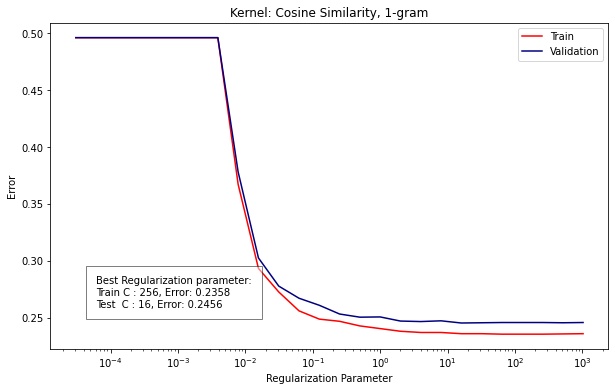

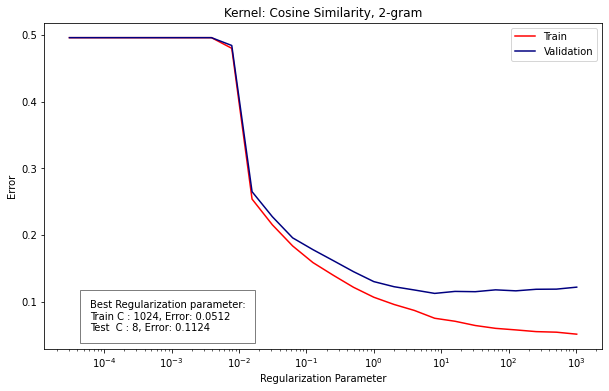

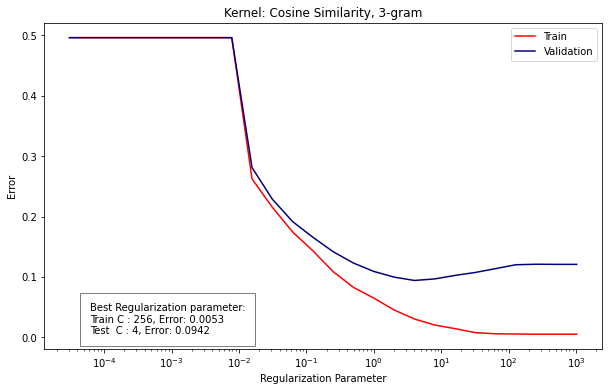

In [0]:
reg_parameters('Cosine Similarity', K1_n, target_train)

4 0.7550106609808103
8 0.8769722814498935
2 0.8957356076759062


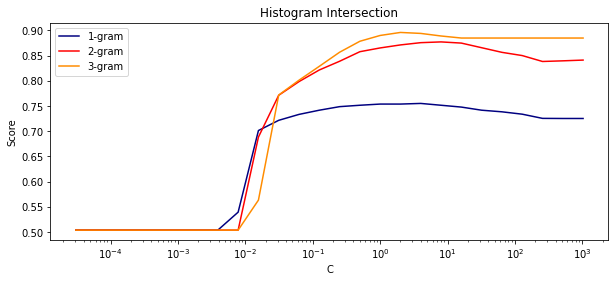

In [0]:
reg_parameters('Histogram Intersection', K2_n, target_train)

1 0.740724946695096
2 0.6628997867803837
2 0.562046908315565


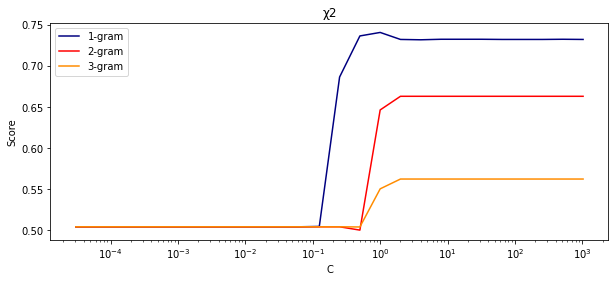

In [0]:
reg_parameters('χ2', K3_n, target_train)

In [0]:
cs = [2**(i) for i in range(-15, 11)]
ssk_kernels = get_scores(K4, target_train, cs)

In [0]:
ssk_kernels

array([0.50383795, 0.50383795, 0.50383795, 0.50383795, 0.50383795,
       0.50383795, 0.50383795, 0.50383795, 0.6217484 , 0.69722814,
       0.72196162, 0.7326226 , 0.73880597, 0.74648188, 0.74925373,
       0.74904051, 0.75266525, 0.75309168, 0.75245203, 0.754371  ,
       0.75415778, 0.75394456, 0.75394456, 0.75394456, 0.75415778,
       0.75394456])

In [0]:
print(cs[np.argmax(ssk_kernels)], ssk_kernels[np.argmax(ssk_kernels)])

16 0.7543710021321961


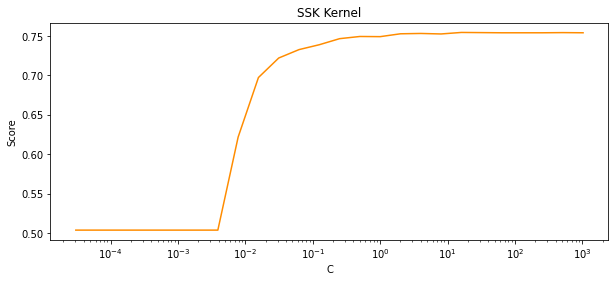

In [0]:
fig, axes = plt.subplots( figsize=(10, 4))
axes.set_xlabel('C')
axes.set_ylabel('Score')
axes.set_title('SSK Kernel')
colors = ['navy', 'red', 'darkorange']
axes.semilogx(cs, ssk_kernels, color='darkorange')
plt.show()

## Problem 1(d)

Evaluate the performance of the SVMs in the test data set:
* Report the results in a table for the different evaluated configurations.
* Illustrate examples of errors (English words mistaken as Spanish, Spanish words
mistaken as English). Give a possible explanation for these mistakes.
* Discuss the results.


In [0]:
def evaluate_svm(kernel_function, kernel_name, n_grams, C):
  reports = []
  for idx, n in enumerate(n_grams):
    _clf = svm.SVC(kernel=kernel_function, C=C[idx])
    _clf.fit(n['train'], target_train)
    predicted = _clf.predict(n['test'])
    nt = len(target_validation)
    errors = np.sum(predicted != target_validation)
    accuracy = 1-(errors/nt)
    reports.append({
        'name': kernel_name,
        'n_gram': f'{idx + 1}-gram',
        'C': C[idx],
        'accuracy': accuracy
    })
  return reports


In [0]:
models = [{
    'kernel': cosine_similarity,
    'C':[16 ,8 ,4],
    'name': 'Cosine Similarity'
}]
'''{
    'kernel': histogram_kernel,
    'C':[16 ,8 ,4],
    'name': 'Histogram Intersection'
}
'''
table = []
for model in models:
  table = table + evaluate_svm(model['kernel'], model['name'], n_grams, model['C'])
results = pd.DataFrame.from_dict(table)

In [0]:
results

,name,n_gram,C,accuracy
0,Cosine Similarity,1-gram,16,0.771861
1,Cosine Similarity,2-gram,8,0.905195
2,Cosine Similarity,3-gram,4,0.924675


In [0]:
models = [{
    'kernel': histogram_kernel,
    'C':[4 ,8 ,2],
    'name': 'Histogram Intersection'
}]
table = []
for model in models:
  table = table + evaluate_svm(model['kernel'], model['name'], n_grams, model['C'])
results = pd.DataFrame.from_dict(table)

In [0]:
reports = []
C = [1,2,2]
for idx, n in enumerate(n_grams):
  _clf = svm.SVC(kernel=chi2_kernel, C=C[idx])
  _clf.fit(n['train'].todense(), target_train)
  predicted = _clf.predict(n['test'].todense())
  nt = len(target_validation)
  errors = np.sum(predicted != target_validation)
  accuracy = 1-(errors/nt)
  reports.append({
      'name': 'X2',
      'n_gram': f'{idx + 1}-gram',
      'C': C[idx],
      'accuracy': accuracy
  })


In [0]:
pd.DataFrame.from_dict(reports)

,name,n_gram,C,accuracy
0,X2,1-gram,1,0.780952
1,X2,2-gram,2,0.731169
2,X2,3-gram,2,0.619913


## Problem 2(a)

**SVM interpretability**

Use the same dataset from question 1 and calculate a bag of n-grams representation.



We consider (1-3)-grams to create the vectorizer because this representantion gave the best model for the histogram representation.

In [0]:
# # Apply vectorizer function with diferent ngrams

# def vectorize_data(data_train_p, data_test_p, ngram_min, ngram_max):
#   ## Transform to bag of words representation. n-gram
#   vectorizer = CountVectorizer(ngram_range = (ngram_min, ngram_max), analyzer = 'char')
#   X_train = vectorizer.fit_transform(data_train_p)
#   X_test = vectorizer.transform(data_test_p)
#   return X_train, X_test

# Apply vectorizer function with diferent ngrams
ngram_min = 1
ngram_max = 3
vectorizer = CountVectorizer(ngram_range = (ngram_min, ngram_max), analyzer = 'char')

# Vectorice the data
X1_train = vectorizer.fit_transform(data_train)
X1_test = vectorizer.transform(data_validation)

X1_train.shape, X1_test.shape

((4690, 3082), (2310, 3082))

In [0]:
X1_train, X1_test = vectorize_data(data_train, data_validation, 1, 3)
X1_train.shape, X1_test.shape

((4690, 3082), (2310, 3082))

## Problem 2(b)

Train a SVM using the histogram intersection kernel on this dataset.

In [0]:
# Apply Histogram Kernel Function
def histogram_kernel(X_p, X_p2):
  N1 = X_p/np.sum(X_p, axis=1).reshape(-1, 1)
  N2 = X_p2/np.sum(X_p2, axis=1).reshape(-1, 1)
  K2_a = np.zeros((N1.shape[0], N2.shape[0]))
  for d in range(N1.shape[1]):
    column_1 = N1[:, d].reshape(-1, 1)
    column_2 = N2[:, d].reshape(-1, 1)
    K2_a += np.minimum(column_1, column_2.T)   
  return K2_a 

In [0]:
histogram_kernel(np.array([[0.2, 0.3],[0.1, 0.4],[0.3,0.2]]), np.array([[0.2, 0.3],[0.1, 0.4]]))

array([[1. , 0.8],
       [0.8, 1. ],
       [0.8, 0.6]])

In [0]:
clf = svm.SVC(C=2.0, kernel=histogram_kernel)
clf.fit(X1_train, target_train)

SVC(C=2.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function histogram_kernel at 0x7f92cf904ea0>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
pred = clf.predict(X1_test)

In [0]:
nt = len(target_validation)
errors = np.sum(pred != target_validation)
accuracy = 1-(errors/nt)
accuracy

0.9168831168831169

In [0]:
pred2 = clf.predict(X1_train)

In [0]:
nt = len(target_train)
errors = np.sum(pred2 != target_train)
accuracy = 1-(errors/nt)
accuracy

0.9624733475479744

### Discuss

The best model from point 1 for the histogram Kernel has $C=2.0$ and (1-3)gram representation.

Which has $96.2\%$  accuracy on (train, validation) data , and $91.7\%$ accuracy on test data.



## Problem 2(c) 

Identify the support vectors found by the SVM training algorithm. Show the samples
corresponding to the support vectors with the maximum absolute value of the $\alpha_i$ coefficients, for both positive and negative values. Do they make sense? Analyze and
discuss.

First we compute the support vectors, and show some examples, in total we have 1892 support vectors

In [0]:
indices = clf.support_
data_train.iloc[indices]

3739       hemos
4664    escribir
6090      medias
5663    probable
6642     conocen
          ...   
1806        ruin
1184        gray
1685       apart
3444       canoe
3092     charges
Name: Word, Length: 1892, dtype: object

Now we compute the support vectors whose alphas in the dual representation are maximal which happen to be that they are equal to 2, given that $C=2.0$. In total we have 994 with highest alphas. Some of thm correpond to the negative class so the dual coefficientes are - 2 and the positive class the dual coefficients are +2

In [0]:
coeffs = clf.dual_coef_
print(coeffs)
print(max(coeffs[0]))
abs_max_coeffs = np.where(abs(coeffs[0]) == 2)
print(len(abs_max_coeffs[0]))

[[-2.         -0.50450222 -0.77823828 ...  2.          2.
   1.25804815]]
2.0
994


In [0]:
data_train.iloc[indices[abs_max_coeffs[0]]].iloc[:40]

3739         hemos
5663      probable
5833       fortuna
5303       deporte
3758        quiere
5123      juventud
6716       balance
3505         entre
4436         lunes
4825        piedra
5605        serian
4387        ocurre
6715        taller
3641        parece
5609        pintor
4714       hacerse
5613        cierre
6967      extremos
4602         tarea
4274          area
6615         senti
4556    superficie
5646    conclusion
6577      misterio
5499         perro
3682        traves
4271         dicen
4456       alcalde
3625         tener
6471          pepe
6797        patron
4048         tomar
4677       version
3857      personal
6815        robert
5239        jardin
6119       alfredo
4299      material
4704          cabe
5900       lideres
Name: Word, dtype: object

We print some examples of support vectors whose alphas are either -2, or +2

### Positive Support vectors

Now we compute the support vectors whose alphas in the dual representation are maximal which means that they are +2, given that $C=2.0$. In total we have 504 maximal positive support vectors.

In [0]:
coeffs = clf.dual_coef_
print(coeffs)
print(max(coeffs[0]))
max_coeffs = np.where(coeffs[0] == max(coeffs[0]))
print(len(max_coeffs[0]))

[[-2.         -0.50450222 -0.77823828 ...  2.          2.
   1.25804815]]
2.0
504


We print some examples of maximal positive support vectors, they are whose alphas are +2 and class +1.

In [0]:
data_train.iloc[indices[max_coeffs[0]]].iloc[:40]

2103           china
1614         escaped
837             plan
1230       principle
3125      ridiculous
1780          actual
803           ladies
3341          mirror
1288    intellectual
718           garden
2364       abandoned
670            value
2641           elder
3006         gardens
3107       criticism
2513         intense
3406         recover
2666        moreover
2815          maiden
1200          divine
566           please
2099         reduced
1688          labour
745          america
741         religion
2170        readable
1911           bosom
2366          eleven
1361         arrival
1526       practical
945         opposite
1503         control
2687         liberal
841          conduct
1189          virtue
175            until
300             care
1472          stones
2642          signal
744         personal
Name: Word, dtype: object

### Negative Support vectors

Now we compute the support vectors whose alphas in the dual representation are maximal they happen to be +2 but are from the negative class -1, hence the coefficients in the dual representation are -2, given that $C=2.0$. In total we have 490 maximal negative support vectors.

In [0]:
coeffs = clf.dual_coef_
print(coeffs)
print(min(coeffs[0]))
min_coeffs = np.where(coeffs[0] == min(coeffs[0]))
print(len(min_coeffs[0]))

[[-2.         -0.50450222 -0.77823828 ...  2.          2.
   1.25804815]]
-2.0
490


We print some examples of maximal negative support vectors, they happen to be those whose alphas are 2 and dual coeffs are -2.

In [0]:
data_train.iloc[indices[min_coeffs[0]]].iloc[0:40]

3739         hemos
5663      probable
5833       fortuna
5303       deporte
3758        quiere
5123      juventud
6716       balance
3505         entre
4436         lunes
4825        piedra
5605        serian
4387        ocurre
6715        taller
3641        parece
5609        pintor
4714       hacerse
5613        cierre
6967      extremos
4602         tarea
4274          area
6615         senti
4556    superficie
5646    conclusion
6577      misterio
5499         perro
3682        traves
4271         dicen
4456       alcalde
3625         tener
6471          pepe
6797        patron
4048         tomar
4677       version
3857      personal
6815        robert
5239        jardin
6119       alfredo
4299      material
4704          cabe
5900       lideres
Name: Word, dtype: object

### Discuss

Given that the support vectors are vectors that lie in the boundary between English and Spanish, we excepted these vectors to be words that are similar in both english and spanish. 
We found that some of them are very similar in both languages, indeed some are cognates words like (probable, religion, conduct) 

The positive support vectors with highest alpha are words in english that sound spanish, like cognates and words with definite spanish-type-syllabic-structure  like (escaped, virtue, moreover).

The negative support vectors with highest alphas are words in spanish that are similar with english words like cognates such as (ocurre, lideres, personal, version). 

Some letters do not appear in the words examples like (w, ñ) because they are almost exclusive of the languages. 

## Problem 2(d)

For different test samples, calculate the classification manually, i.e. compute the kernel between the sample and the support vectors and check how the contribute, positively or negatively, to the final classification. Show those vectors that have the highest value of the kernel. Analyze and discuss

Print part of the validation data set to select some test sample from English

In [0]:
data_validation[180:220]

3615             cual
6156            vital
473            church
6083            reloj
2886    determination
1554           unable
4127       finalmente
1940         doctrine
6186            pilar
5947        encargado
5459      agricultura
6681           terror
6497       tendencias
6150     conservacion
2900           theyre
1201         material
5714    mantenimiento
6269         revision
535             heavy
5689        consiguio
3733           llegar
5799       consciente
2874            grasp
5178    concentracion
3142             adam
3113     restrictions
3806         comision
5038      extranjeros
4053           amigos
3043           enable
1335             rode
6244        bienestar
2764       previously
5561          interno
1964            reign
1559       constantly
185             white
5531           minuto
5071         producir
6713         montanas
Name: Word, dtype: object

### Sample 1: ['white']

Compute the Kernel between the support vectors and the word

In [0]:
# Select the support vectors and the sample vector
indices = clf.support_
X_supvecs = X1_train[indices]
X_sample = vectorizer.transform(['white'])

# Compute the Kernel
K_1 = histogram_kernel(X_supvecs,X_sample).T

# Select the coefficients in the dual representation and the intercept
coeffs = clf.dual_coef_
b_coeff = clf.intercept_[0]

# Print the resulting shapes
X_supvecs.shape, K_1.shape, coeffs.shape

((1892, 3082), (1, 1892), (1, 1892))

Compute the element wise product of the Kernel between the support vectors and the test sample, and the total discrimination function. 

In [0]:
disc_function = K_1*coeffs
disc_value = disc_function.sum() + b_coeff

disc_value, disc_function.shape

(2.039306326057856, (1, 1892))

Compute the support vectors which have higher positive and negative effect in the classification

In [0]:
min_disc_function = disc_function[0]
#maxvecs = min_disc_function.argsort()[-8:][::-1]
maxvecs = (-min_disc_function).argsort()[:8]
maxvecs.shape

(8,)

In [0]:
data_train.iloc[indices[maxvecs]]

161          quite
2111      hitherto
2750      definite
2139         haste
2451      infinite
1460    excitement
2401     interview
3106      favorite
Name: Word, dtype: object

In [0]:
max_disc_function = disc_function[0]
#maxvecs = min_disc_function.argsort()[-8:][::-1]
minvecs = (max_disc_function).argsort()[:8]
minvecs.shape

(8,)

In [0]:
data_train.iloc[indices[minvecs]]

5659      limite
4573      aceite
4469      comite
4050       siete
4476       hotel
5750        hice
4190       chile
5283    criterio
Name: Word, dtype: object

### Sample 2: ['extranjeros']

Compute the Kernel between the support vectors and the word

In [0]:
# Select the support vectors and the sample vector
indices = clf.support_
X_supvecs = X1_train[indices]
X_sample = vectorizer.transform(['extranjeros'])

# Compute the Kernel
K_1 = histogram_kernel(X_supvecs,X_sample).T

# Select the coefficients in the dual representation and the intercept
coeffs = clf.dual_coef_
b_coeff = clf.intercept_[0]

# Print the resulting shapes
X_supvecs.shape, K_1.shape, coeffs.shape

((1892, 3082), (1, 1892), (1, 1892))

Compute the element wise product of the Kernel between the support vectors and the test sample, and the total discrimination function. 

In [0]:
disc_function = K_1*coeffs
disc_value = disc_function.sum() + b_coeff

disc_value, disc_function.shape

(-1.5174481926773193, (1, 1892))

Compute the support vectors which have higher positive and negative effect in the classification

In [0]:
min_disc_function = disc_function[0]
#maxvecs = min_disc_function.argsort()[-8:][::-1]
maxvecs = (-min_disc_function).argsort()[:8]
maxvecs.shape

(8,)

In [0]:
data_train.iloc[indices[maxvecs]]

1367    extraordinary
3026         external
1537         entrance
1642          extreme
1602            arose
3304           orange
2777         contrast
1714          granted
Name: Word, dtype: object

In [0]:
max_disc_function = disc_function[0]
#maxvecs = min_disc_function.argsort()[-8:][::-1]
minvecs = (max_disc_function).argsort()[:8]
minvecs.shape

(8,)

In [0]:
data_train.iloc[indices[minvecs]]

6967       extremos
4804     transporte
6689    encontrarse
5264     exteriores
4324     encuentran
6858        esperan
4721      personaje
6904    encontraban
Name: Word, dtype: object

### Sample 3: ['constantly']

Compute the Kernel between the support vectors and the word

In [0]:
# Select the support vectors and the sample vector
indices = clf.support_
X_supvecs = X1_train[indices]
X_sample = vectorizer.transform(['constantly'])

# Compute the Kernel
K_1 = histogram_kernel(X_supvecs,X_sample).T

# Select the coefficients in the dual representation and the intercept
coeffs = clf.dual_coef_
b_coeff = clf.intercept_[0]

# Print the resulting shapes
X_supvecs.shape, K_1.shape, coeffs.shape

((1892, 3082), (1, 1892), (1, 1892))

Compute the element wise product of the Kernel between the support vectors and the test sample, and the total discrimination function. 

In [0]:
disc_function = K_1*coeffs
disc_value = disc_function.sum() + b_coeff

disc_value, disc_function.shape

(1.274163082838088, (1, 1892))

Compute the support vectors which have higher positive and negative effect in the classification

In [0]:
min_disc_function = disc_function[0]
#maxvecs = min_disc_function.argsort()[-8:][::-1]
maxvecs = (-min_disc_function).argsort()[:8]
maxvecs.shape

(8,)

In [0]:
data_train.iloc[indices[maxvecs]]

1453      constant
2777      contrast
1303       contact
1781    companions
3174     consisted
1437       contain
499       distance
482      important
Name: Word, dtype: object

In [0]:
max_disc_function = disc_function[0]
#maxvecs = min_disc_function.argsort()[-8:][::-1]
minvecs = (max_disc_function).argsort()[:8]
minvecs.shape

(8,)

In [0]:
data_train.iloc[indices[minvecs]]

4787       instante
5280    constituyen
5297      construir
4775       consiste
6904    encontraban
5373      continuar
6462       consenso
6689    encontrarse
Name: Word, dtype: object

### Discuss

## Problem 2(e)

Propose a method that for a given word to be classified, highlight in one color (e.g. blue)
those n-grams that suggest the word is from English and in another color (e.g. red) those
n-grams that suggest the word is from Spanish.

**Solution:**

Let $\mathbf{p}$ be the word vector to be classified defined by the elements $p_j$, and let $\mathbf{x_i}$ be one support vector, defined by the elements $x_{ij}$. All vectors are normalized. Then the discrimination function for $\mathbf{p}$ is defined by,
$$  f(\mathbf{p}) = \sum_ia_iy_ik(\mathbf{x_i},\mathbf{p}) + b $$
Now the Histogram Kernel function between the points is defined by, 
$$ k(\mathbf{x_i},\mathbf{p}) = \sum_j\text{min}(x_{ij},p_j) $$
Then, 
$$  f(\mathbf{p}) = \sum_ia_iy_i(\sum_j\text{min}(x_{ij},p_j)) + b $$
$$  f(\mathbf{p}) = \sum_j (\sum_ia_iy_i\text{min}(x_{ij},p_j)) + b $$
Hence, we can a define a vector $\mathbf{F}$ where each element apply to each n-gram whose jth entry is, 
$$  F_j  =  \sum_ia_iy_i(\text{min}(x_{ij},p_j)) $$
The positive elements of that vector would be n-grams which suggest the word is from english, the negative elements would be n-grams which suggest is from spanish.


In [0]:
# Select the support vectors and the sample vector
indices = clf.support_
X_supvecs = X1_train[indices]
X_sample = vectorizer.transform(['constantly'])

# Normalize the support vectors and the sample vector
X_supvecs = (X_supvecs/X_supvecs.sum(axis=1)).toarray()
X_sample = X_sample/X_sample.sum()

# Select the dual coefficients of the support vectors
coeffs = clf.dual_coef_.T

# X_supvecs.shape, X_sample.shape, X_supvecs.sum(axis=1)[:2], X_sample.sum(), coeffs.shape

F = np.minimum(X_supvecs,X_sample) 
F.shape

AttributeError: ignored

## Problem 3(a)

**Kernel logistic regression** 

We will implement a kernel version of logistic regression. The goal is to train a logistic
regression model on a feature space F. Specifically, the discriminant function of the model is
given by:

$$f(x) = P(C = 1|x) = \sigma(w\Phi(x))$$


where $\Phi : X \rightarrow F$ is a mapping function associated with a kernel function $k : X \times X \rightarrow R$
and $\sigma$ is the logistic function.

Assume that the weight vector w is expressed as a linear combination of the training samples:

$$w = \sum_{i=1}^l\alpha_i\Phi(x_i)$$

(a) Write a expression of the discriminant function expressed in terms of the kernel and the
coeficients $\alpha_i$.

**Solution:**

The discriminant function can be written as, 
$$f(x) = \sigma(w\Phi(x))=\sigma\big(\big[\sum_{i=1}^l\alpha_i\Phi(x_i)\big]\cdot\Phi(x)\big)$$
$$f(x) = \sigma\big(\sum_{i=1}^l\alpha_i[\Phi(x_i)\cdot\Phi(x)]\big)$$
Hence, 
$$ f(x) = \sigma\big(\sum_{i=1}^l\alpha_i k(x_i,x)\big)$$


## Problem 3(b)

Formulate the problem of learning the parameters of the model as an optimization problem that looks for the parameters $\alpha_i$ that minimize a cross entropy loss function.

**Solution:**

Consider the training points as ${x_i,y_i}$ where the $y_i={0,1}$ are the labels, 
The sample likelihood would be given by Bernoulli, 

$$\prod_i(f(x_i)^{y_i})(1-f(x_i))^{1-y_i}$$

The cross entropy would be the log given by, 

$$L = - \sum_iy_i\log f(x_i)+(1-y_i)\log(1-f(x_i))$$

$$L = - \sum_iy_i\log\Big[\sigma\big(\sum_{j}\alpha_j k(x_j,x_i)\big)\Big]+(1-y_i)\log\Big[1-\sigma\big(\sum_{j}\alpha_j k(x_j,x_i)\big)\Big]$$

Now, let’s write $f(a)=\frac{1}{1-e^{-a}}$, then $f’(a)=f(a)(1-f(a))$

The update by gradient descent would take the form, 

$$\Delta \alpha_j = -\eta \frac{\partial L}{\partial \alpha_i}= \eta\sum_i\Big[\frac{y_i}{f(x_i)}-\frac{1-y_i}{1-f(x_i)}\Big]f(x_i)(1-f(x_i))k(x_j,x_i) $$

Finally in short form, 

$$\Delta \alpha_j = \eta \sum_i(y_i-f(x_i))k(x_j,x_i)$$

That would be the training of the alphas

## Problem 3(c)

Write a function that receives a training data set and a kernel function and finds a vector that minimizes the loss function using gradient descent.

In [0]:
def test_model(X_p, alpha_p, kernel_p, y):
  K = kernel_p(X_p, X_p)
  pred_score = sigmoid(alpha_p, K)
  pred = (pred_score > 0.5).astype(int)
  accuracy = 1 - np.sum(pred != y)/len(y)
  return accuracy

In [0]:
### 
### Any auxiliary functions that you need
###
def evaluate_classifier(a,x,pt,kernel_type):
    n,d = x.shape
    sum = 0
    K = kernel_type(x,pt.reshape(1, 2))
    for i in range(n):
      sum += a[i]*K[i]
    if sum > 0:
      return 1
    if sum <= 0:
      return 0

    return -1

In [0]:
def sigmoid(alpha_p, kmatrix_p):
  #return 1/(1+np.exp(-((np.dot(kmatrix_p, alpha_p))+bias_p)))
  return 1/(1+np.exp(-(np.dot(kmatrix_p, alpha_p))))

In [0]:
def train_kernel(x,y,eta,n_iters=100,kernel_type=polynomial_kernel):
  n,d = x.shape
  a = (np.random.rand(n) * 0.02) - 0.01  # (l, )
  K = kernel_type(x, x)
  done = False
  iters = 0
  np.random.seed(None)
  while not(done):
    done = True
    a_temp = a
    for j in range(n):
      a[j] = a[j] + eta * np.dot((y - sigmoid(a_temp, K)), K[j] )
      done = False
    iters = iters + 1
    if iters > n_iters:
      done = True

  return a

## Problem 3(d)

Test your algorithm using diferent kernels (linear, polynomial, Gaussian, etc.) on synthetic 2D datasets from sklearn (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html). Plot the decision regions and
discuss the results:

In [0]:
# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(alpha_p, X, kernel_p):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            pt = np.array([XX[i, j] , YY[i, j]])
            ZZ[i, j] = evaluate_classifier(alpha_p,X,pt,kernel_p)
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

### Moons Logistic Linear Kernel

In [0]:
X, y = make_moons(n_samples=250, noise=0.15, random_state=0)
X.shape, y.shape

((250, 2), (250,))

In [0]:
alpha = train_kernel(X,y,0.01,300,linear_kernel)

In [0]:
accuracy = test_model(X, alpha, linear_kernel, y)
accuracy

0.872

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


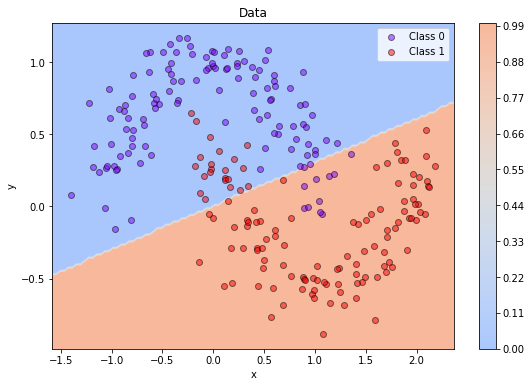

In [0]:
pl.figure(figsize = (9, 6))
plot_decision_region(alpha, X, linear_kernel) 
plot_data(X, y)

### Moons Logistic 3-deg Polinomial Kernel

In [0]:
alpha = train_kernel(X,y,0.01,300, polynomial_kernel)

In [0]:
accuracy = test_model(X, alpha, polynomial_kernel, y)
accuracy

0.972

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


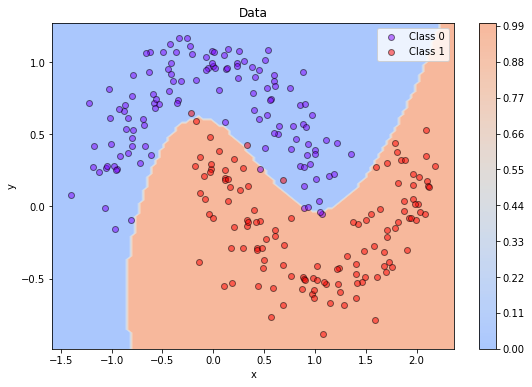

In [0]:
pl.figure(figsize = (9, 6))
plot_decision_region(alpha, X, polynomial_kernel) 
plot_data(X, y)

### Moons Logistic Gaussian Kernel

In [0]:
alpha = train_kernel(X,y,0.01,300,rbf_kernel)

In [0]:
accuracy = test_model(X, alpha, rbf_kernel, y)
accuracy

0.968

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


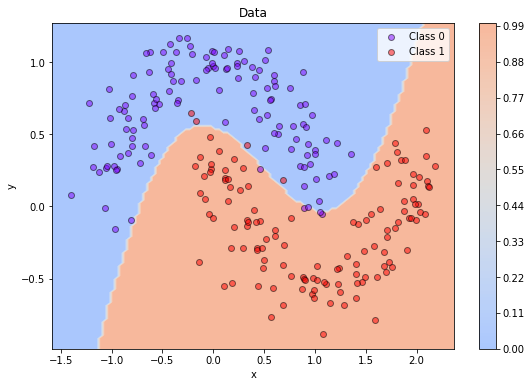

In [0]:
pl.figure(figsize = (9, 6))
plot_decision_region(alpha, X, rbf_kernel) 
plot_data(X, y)

### Circles Logistic Linear Kernel

In [0]:
X, y = make_circles(n_samples=250, factor=.3, noise=.35)
X.shape, y.shape

((250, 2), (250,))

In [0]:
alpha = train_kernel(X,y,0.01,300,linear_kernel)

In [0]:
accuracy = test_model(X, alpha, linear_kernel, y)
accuracy

0.516

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


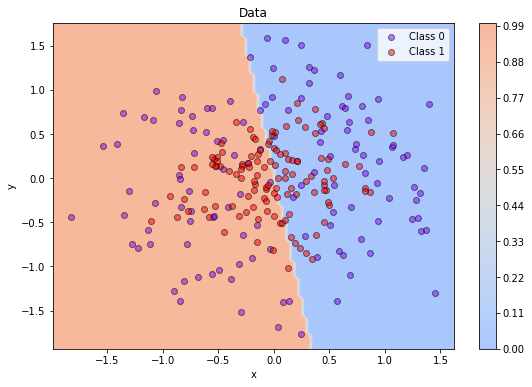

In [0]:
pl.figure(figsize = (9, 6))
plot_decision_region(alpha, X, linear_kernel) 
plot_data(X, y)

### Circles Logistic 3-deg Polinomial Kernel

In [0]:
alpha = train_kernel(X,y,0.01,300, polynomial_kernel)

In [0]:
accuracy = test_model(X, alpha, polynomial_kernel, y)
accuracy

0.8200000000000001

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


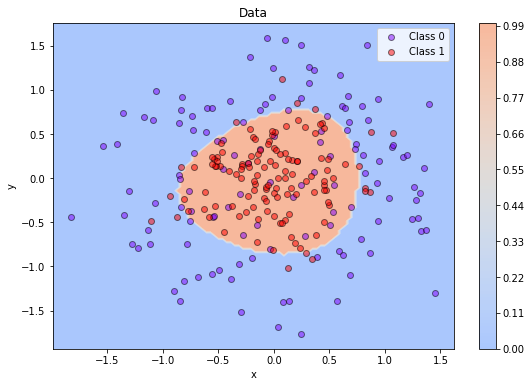

In [0]:
pl.figure(figsize = (9, 6))
plot_decision_region(alpha, X, polynomial_kernel) 
plot_data(X, y)

### Circles Logistic Gaussian Kernel

In [0]:
alpha = train_kernel(X,y,0.01,300,rbf_kernel)

In [0]:
accuracy = test_model(X, alpha, rbf_kernel, y)
accuracy

0.8160000000000001

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


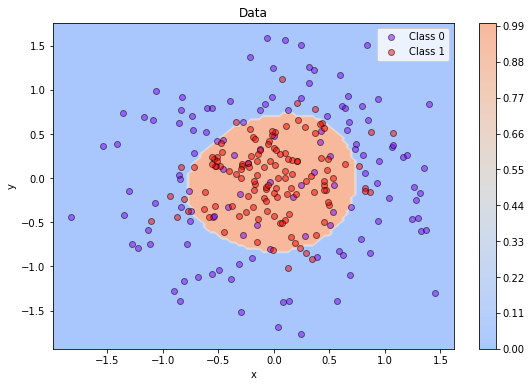

In [0]:
pl.figure(figsize = (9, 6))
plot_decision_region(alpha, X, rbf_kernel) 
plot_data(X, y)

### Discuss

We have trained two binary data sets, one made of moons and another of circles, with three different Logistic Kernels (Linear, 3-deg polynomial, Gaussian). The accuracy on the trained points are shown in the following table. 

| | Accuracy | | |
|---|:-:|:-:|:-:|
|**Data**   |Linear|3-Polynomial |Gaussian|
|Moons|  84.4 |  94.0 | 92.0 |
|Circles|  50.4 | 82.0  | 82.8 | 

Given that the data was not chosen separable, we do not have 100 accuracy.
We see that the linear kernel performs very bad for circles. The 3-deg polynomial performs the best for moons , and the gaussian performs the best for circles.

In the plots we see that for circles data the linear Kernel classifies as only one class, the gaussian kernel has a greater boundary region for class 1 compared with 3-deg polynomial.

The moons are better classified given that the points in the data set overlap less compared with the points in the circles data set.